In [2]:
import os
import folium
import pandas as pd

root_folder = "/home/trungdc/unimelb/MAST30024/asm/mast30034_2021_s2_project_1-alexdang02-1"
data_dir = os.path.join(root_folder, "Data")
SQLOutput_dir = os.path.join(root_folder, "code/SparkSQL_Output")
plot_dir = os.path.join(root_folder, "Plots")

In [2]:
import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [3]:
from pyspark.sql import SparkSession
import warnings
warnings.filterwarnings("ignore")
spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.execution.arrow.pyspark.enabled', True)
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

In [25]:
sdf = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(os.path.join(data_dir,"Merge", "train.csv"))
sdf.createOrReplaceTempView("trip")
sdf.limit(5)

VendorID,tpep_pickup_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration(m),expected_total_distance(miles),expected_total_duration(s),tempMax,tempMin,tempAvg,tempDeparture,hdd,cdd,precipitation,newSnow,snowDepth
2,2018-08-07 09:52:38,2,12,3,1,156,2,52.0,0.0,0.0,0.0,18.25,0.3,70.55,18.0,3.0,714.7,89.7,74.2,81.9,4.8,0.0,17.2,0.4,0.0,0.0
2,2018-12-02 01:54:26,3,17,1,100,11,1,50.5,0.5,0.5,4.2,0.0,0.3,56.0,41.0,15.0,1670.4,55.5,42.7,49.1,6.8,15.5,0.0,0.8,0.0,0.0
1,2018-01-04 05:20:05,1,16,1,100,11,2,44.5,0.5,0.5,0.0,0.0,0.3,45.8,24.0,15.0,1670.4,29.0,19.0,24.0,-10.2,40.8,0.0,0.6,8.3,1.0
2,2018-12-07 16:31:34,2,13,1,100,11,1,43.5,1.0,0.5,10.21,5.76,0.3,61.27,45.0,15.0,1670.4,39.7,26.7,33.2,-7.7,31.7,0.0,0.0,0.0,0.0
1,2018-01-05 20:07:25,1,13,1,100,11,1,40.5,0.5,0.5,9.5,5.76,0.3,57.06,36.0,15.0,1670.4,19.0,9.2,14.1,-20.0,50.8,0.0,0.1,0.0,7.4


In [8]:
def weekend(dayofweek):
  if   dayofweek <= 5: 
      return 0
  else:
      return 1
udfWeekendFunc = F.udf(weekend, IntegerType())

def workingHour(hour, weekend):
    if weekend <= 5:
        if 7 <= hour <= 19:
            return 1
        else:
            return 0
    else:
        return 0
udfworkingHour = F.udf(workingHour, IntegerType())

In [ ]:
def preprocess(sdf):
    sdf = sdf.withColumn("tpep_pickup_datetime", to_timestamp(sdf.tpep_pickup_datetime, 'yyyy-MM-dd HH:mm:ss') ) \
    .withColumnRenamed("duration(m)", "duration")  \
    .withColumnRenamed('expected_total_distance(miles)', "expected_total_distance") \
    .withColumnRenamed('expected_total_duration(s)', "expected_total_duration") 
    sdf = sdf.withColumn("expected_total_duration", sdf.expected_total_duration/60)
    sdf = sdf.filter(sdf.passenger_count <= 6) \
        .filter(sdf.PULocationID != sdf.DOLocationID) \
        .filter( ~ ((sdf.RatecodeID == 2) & (sdf.fare_amount <= 50))) \
        .filter(sdf.duration < 500) \
        .filter(sdf.total_amount >= 2.5) \
        .filter(sdf.tolls_amount >= 0) \
        .filter(sdf.VendorID.isin([1,2])) \
        .filter(sdf.RatecodeID.isin([1,2])) \
        .filter(sdf.payment_type.isin([1,2])) \
        .filter(sdf.tip_amount <= 25) \
    .withColumn("DayofWeek", dayofweek(sdf.tpep_pickup_datetime))   \
    .withColumn("Weekend", udfWeekendFunc(col("DayofWeek"))) \
    .withColumn("Month", month(sdf.tpep_pickup_datetime))   \
    .withColumn("Hour", hour(sdf.tpep_pickup_datetime)) 

    sdf = sdf.withColumn("WorkingHour", udfworkingHour(col("Hour"), col("DayofWeek"))) \
    .withColumn("trip_distance",F.when(sdf.trip_distance==0, sdf.expected_total_distance).otherwise(sdf.trip_distance)) \
    .withColumn("passenger_count", F.when(sdf.passenger_count==0, 1).when(sdf.passenger_count==6, 5).otherwise(sdf.passenger_count)) \
    .withColumn("tip_amount", F.when(sdf.tip_amount<0, 0).otherwise(sdf.tip_amount)) \
    .withColumn("fare_amount", F.when(sdf.fare_amount<2.5, 2.5).otherwise(sdf.fare_amount)) \
    .withColumn("Key", concat(sdf.DayofWeek,lit(","), sdf.Hour )) \
    .drop("expected_total_distance", "expected_total_duration", "tpep_pickup_datetime")
    return sdf
sdf = preprocess(sdf)
sdf.createOrReplaceTempView("trip")

In [ ]:
querry ="""
SELECT Key, COUNT(*) AS FREQUENCY
FROM trip
GROUP BY Key
"""
out = spark.sql(querry)
out.repartition(1).write.csv(os.path.join(SQLOutput_dir, "2018TimeFrequency.csv"), header=True)


In [3]:
def readSparkSQLOutput(output_name):
    output_path = os.path.join(SQLOutput_dir, output_name)
    csvfile = [file for file in os.listdir(output_path) if file.endswith(".csv")][0]
    df = pd.read_csv(os.path.join(output_path, csvfile))
    return df
df=  readSparkSQLOutput("2018TimeFrequency.csv")

In [4]:
hours = []
days = []
for index, row in df.iterrows():
    day, hour = row["Key"].split(",")
    days.append(int(day))
    hours.append(int(hour))
df["day"] = days
df["hour"] = hours
new_df = df.sort_values(["day", "hour"])
my_list= list(new_df["FREQUENCY"])
n = 24
final = [my_list[i * n:(i + 1) * n] for i in range((len(my_list) + n - 1) // n )] 

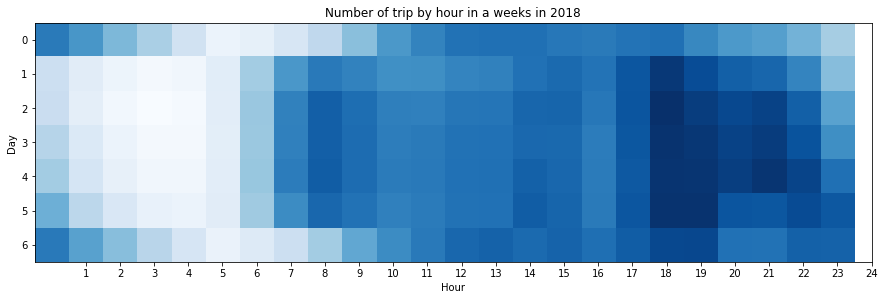

/home/trungdc/anaconda3/envs/mast30024asm1/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  app.launch_new_instance()


In [6]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots()
pos = ax.imshow(final, cmap='Blues', interpolation='nearest')

ax.set_xticks(ticks=range(1,25))
# ax.set_yticks(ticks = range(0,7))
ax.set_ylabel(ylabel=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
ax.set_xlabel("Hour")
ax.set_ylabel("Day")
ax.set_title("Number of trip by hour in a weeks in 2018")
plt.show()
fig.tight_layout()
# c = plt.pcolor(my_list, edgecolors='k', linewidths=4, cmap='Blues', vmin=0.0, vmax=1.0)
fig.colorbar(pos, ax = ax)
fig.savefig(os.path.join(plot_dir, "2018trip_distribution.jpg"), tight_layout = True)
